# Text Generation with Recurrent Neural Networks (RNNs)

In this assignment, you'll build upon your understanding of RNNs and Keras to develop a word-level text generation model.  Your goal is to train a model that learns the stylistic nuances of a chosen corpus and generates new, original text segments that echo the source material's essence.

**Datasets**

We've provided several intriguing text corpora to get you started:

*   Mark Twain
*   Charles Dickens
*   William Shakespeare

**Feel free to explore!**  If you have a particular passion for another author, genre, or a specific text, you're encouraged to use your own dataset of raw text.

In [1]:
pip install numpy pandas keras tensorflow


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Check if we have a GPU available
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU available. If you're on Colab, go to Runtime > Change runtime and select a GPU hardware accelerator.")

2024-08-04 15:50:07.376991: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-04 15:50:08.319025: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-04 15:50:08.623046: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-04 15:50:09.192767: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-04 15:50:09.335890: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-04 15:50:10.315857: I tensorflow/core/platform/cpu_feature_gu

No GPU available. If you're on Colab, go to Runtime > Change runtime and select a GPU hardware accelerator.


In [2]:
def download_file(url, file_path):
    import requests
    r = requests.get(url)
    with open(file_path, 'wb') as f:
        f.write(r.content)

def load_dataset(file_path, fraction=1.0):
    with open(file_path, 'r', encoding='utf-8') as f:
        raw_text = f.read()
    return raw_text[:int(fraction * len(raw_text))]

dataset = 'shakespeare.txt' # Other options are mark_twain.txt, charles_dickens.txt

download_file(f'https://github.com/UofT-DSI/deep_learning/raw/main/assignments/downloaded_books/' + dataset, dataset)

# Load chosen dataset. NOTE: If Colab is running out of memory, change the `fraction` parameter to a value between 0 and 1 to load less data.
text = load_dataset(dataset, fraction=0.1)

# 1. Data Preparation (Complete or Incomplete)

Before we can begin training an RNN model, we need to prepare the dataset. This involves cleaning the text, tokenizing words, and creating sequences the model can be trained on.

## 1.1 Data Exploration

Print the first 1000 characters of the dataset. Report the dataset's size and the number of unique characters it contains.

In [4]:
def data_exploration(text):
    # Print the first 1000 characters of the dataset
    sample_text = text[:1000]
    print("First 1000 characters of the dataset:")
    print(sample_text)
    print("\n")

    # Report the dataset's size
    text_size = len(text)
    print(f"Dataset size: {text_size} characters")
    
    # Count the number of unique characters
    unique_characters = set(text)
    num_unique_characters = len(unique_characters)
    print(f"Number of unique characters: {num_unique_characters}")

# Load your dataset
dataset = 'shakespeare.txt'  
text = load_dataset(dataset, fraction=1.0) 

# Perform data exploration
data_exploration(text)


First 1000 characters of the dataset:






<!DOCTYPE html>
<html
  lang="en"
  
  data-color-mode="auto" data-light-theme="light" data-dark-theme="dark"
  data-a11y-animated-images="system" data-a11y-link-underlines="true"
  >



  <head>
    <meta charset="utf-8">
  <link rel="dns-prefetch" href="https://github.githubassets.com">
  <link rel="dns-prefetch" href="https://avatars.githubusercontent.com">
  <link rel="dns-prefetch" href="https://github-cloud.s3.amazonaws.com">
  <link rel="dns-prefetch" href="https://user-images.githubusercontent.com/">
  <link rel="preconnect" href="https://github.githubassets.com" crossorigin>
  <link rel="preconnect" href="https://avatars.githubusercontent.com">

  

  <link crossorigin="anonymous" media="all" rel="stylesheet" href="https://github.githubassets.com/assets/light-efd2f2257c96.css" /><link crossorigin="anonymous" media="all" rel="stylesheet" href="https://github.githubassets.com/assets/dark-6b1e37da2254.css" /><link data-color-theme="dark

## 1.2 Text Pre-Processing

To prepare the dataset for training, we need to clean the text and create a numerical representation the model can interpret. Perform the following pre-processing steps:

*   Convert the entire text to lowercase.
*   Use the `Tokenizer` class from the `keras.preprocessing.text` module to tokenize the text. You should fit the tokenizer on the text and then convert the text to a sequence of numbers. You can use the `texts_to_sequences` method to do this.

**Note**:
* You'll need to specify an appropriate size for the vocabulary. The number of words in the list of most common words can serve as a guide - does it seem like a reasonable vocabulary size?
* Some of the words will be excluded from the vocabulary, as they don't appear often enough. It's important to provide a value for `oov_token` when creating the Tokenizer instance, so that these words can be represented as "unknown".

In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Define constants
VOCAB_SIZE = 10000  # Adjust this based on the dataset's vocabulary size
OOV_TOKEN = '<OOV>'  # Token for out-of-vocabulary words

# Initialize the Tokenizer with the specified vocabulary size and OOV token
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token=OOV_TOKEN)

# Load and preprocess the dataset
text = load_dataset(dataset, fraction=1.0)
text = text.lower()  # Convert text to lowercase

# Fit the tokenizer on the text
tokenizer.fit_on_texts([text])

# Convert text to sequences
sequences = tokenizer.texts_to_sequences([text])[0]

# Show some statistics
print(f"Vocabulary size: {len(tokenizer.word_index)}")
print(f"Number of unique words in the text: {len(set(sequences))}")
print(f"First 50 sequences: {sequences[:50]}")

# Optionally, view the word-to-index mapping
print("\nSample word-to-index mapping:")
for word, index in list(tokenizer.word_index.items())[:10]:
    print(f"{word}: {index}")


Vocabulary size: 5825
Number of unique words in the text: 5824
First 50 sequences: [1613, 462, 462, 1118, 877, 11, 52, 1119, 179, 11, 250, 259, 250, 11, 203, 259, 203, 11, 1120, 1614, 1121, 1615, 11, 1120, 10, 1616, 17, 1122, 82, 463, 464, 32, 10, 122, 673, 674, 33, 24, 14, 67, 25, 10, 122, 673, 674, 33, 24, 1123, 878, 25]

Sample word-to-index mapping:
<OOV>: 1
0: 2
1: 3
quot: 4
75: 5
25: 6
2: 7
class: 8
3: 9
link: 10


If everything worked, the following line should show you the first 10 words in the vocabulary:

In [6]:
try:
    print(list(tokenizer.word_index.items())[:10])
except AttributeError:
    print("Tokenizer has not been initialized. Possible issue: Complete the relevant section of the assignment to initialize it."
)


[('<OOV>', 1), ('0', 2), ('1', 3), ('quot', 4), ('75', 5), ('25', 6), ('2', 7), ('class', 8), ('3', 9), ('link', 10)]


## 1.3 Sequence Generation

Now that the text has been tokenized, we need to create sequences the model can be trained on. There are two parts to this:

*   Use the `texts_to_sequences` method from the tokenizer to convert the text to a list of sequences of numbers.
*   Generate the training sequences. Each training sequence should contain `SEQ_LENGTH` token IDs from the text. The target token for each sequence should be the word that follows the sequence in the text.

In [7]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Define the sequence length
SEQ_LENGTH = 50  # Adjust this based on your model's requirements

# Convert the text to a list of sequences of numbers
sequences = tokenizer.texts_to_sequences([text])[0]

# Generate the training sequences
X = []
y = []

# Create sequences of SEQ_LENGTH and corresponding target tokens
for i in range(SEQ_LENGTH, len(sequences)):
    X.append(sequences[i - SEQ_LENGTH:i])
    y.append(sequences[i])

# Convert lists to numpy arrays for compatibility with Keras
X = np.array(X)
y = np.array(y)

# Optionally, convert y to one-hot encoding if needed for classification
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, num_classes=len(tokenizer.word_index) + 1)

# Print out some details to verify
print(f"Number of sequences: {len(X)}")
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")
print(f"First training sequence (X[0]): {X[0]}")
print(f"First target token (y[0]): {y[0]}")


Number of sequences: 31530
Shape of X: (31530, 50)
Shape of y: (31530, 5826)
First training sequence (X[0]): [1613  462  462 1118  877   11   52 1119  179   11  250  259  250   11
  203  259  203   11 1120 1614 1121 1615   11 1120   10 1616   17 1122
   82  463  464   32   10  122  673  674   33   24   14   67   25   10
  122  673  674   33   24 1123  878   25]
First target token (y[0]): [0. 0. 0. ... 0. 0. 0.]


Assuming your sequences are stored in `X` and the corresponding targets in `y`, the following line should print the first training sequence and its target:

In [8]:
if len(X) > 0 and len(y) > 0:
    # Print the first training sequence and its target
    print(f'Sequence: {X[0]}')

    # Check if y is one-hot encoded and get the target index
    if len(y.shape) > 1 and y.shape[1] > 1:
        target_index = np.argmax(y[0])  # Get the index from the one-hot encoded array
    else:
        target_index = y[0]  # Directly use if y is not one-hot encoded
    
    print(f'Target index: {target_index}')

    # Translate back to words using the tokenizer
    sequence_words = [tokenizer.index_word.get(i, '<OOV>') for i in X[0]]
    target_word = tokenizer.index_word.get(target_index, '<OOV>')

    print(f'Translated back to words: {sequence_words} -> {target_word}')
else:
    print("Training sequences have not been generated. Possible issue: Complete the relevant section of the assignment to initialize it.")


Sequence: [1613  462  462 1118  877   11   52 1119  179   11  250  259  250   11
  203  259  203   11 1120 1614 1121 1615   11 1120   10 1616   17 1122
   82  463  464   32   10  122  673  674   33   24   14   67   25   10
  122  673  674   33   24 1123  878   25]
Target index: 10
Translated back to words: ['doctype', 'html', 'html', 'lang', 'en', 'data', 'color', 'mode', 'auto', 'data', 'light', 'theme', 'light', 'data', 'dark', 'theme', 'dark', 'data', 'a11y', 'animated', 'images', 'system', 'data', 'a11y', 'link', 'underlines', 'true', 'head', 'meta', 'charset', 'utf', '8', 'link', 'rel', 'dns', 'prefetch', 'href', 'https', 'github', 'githubassets', 'com', 'link', 'rel', 'dns', 'prefetch', 'href', 'https', 'avatars', 'githubusercontent', 'com'] -> link


And the following code will transform y into a one-hot encoded matrix, and split everything into training and validation sets:

In [9]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import numpy as np

# Ensure that tokenizer has been initialized
if tokenizer is not None:
    # Convert X and y to numpy arrays
    X = np.array(X)
    y = np.array(y)

    # Convert one-hot encoded y to indices if necessary
    if len(y.shape) > 1 and y.shape[1] > 1:
        y_indices = np.argmax(y, axis=1)  # Convert one-hot to indices
    else:
        y_indices = y

    # Check if OOV_TOKEN is in tokenizer and create mask accordingly
    if OOV_TOKEN in tokenizer.word_index:
        oov_index = tokenizer.word_index[OOV_TOKEN]
        mask = y_indices != oov_index  # Create a mask to filter out OOV tokens

        # Apply mask to X and y
        X = X[mask]
        y_indices = y_indices[mask]

        # Reapply one-hot encoding after filtering
        y = to_categorical(y_indices, num_classes=VOCAB_SIZE)
    else:
        # If OOV_TOKEN is not in tokenizer, apply one-hot encoding directly
        y = to_categorical(y_indices, num_classes=VOCAB_SIZE)

    # Split the data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    print(f'X_train shape: {X_train.shape}')
    print(f'y_train shape: {y_train.shape}')
    print(f'X_val shape: {X_val.shape}')
    print(f'y_val shape: {y_val.shape}')
else:
    print("Tokenizer has not been initialized. Please initialize it and load the vocabulary before continuing.")


X_train shape: (25224, 50)
y_train shape: (25224, 10000)
X_val shape: (6306, 50)
y_val shape: (6306, 10000)


# 2. Model Development (Complete or Incomplete)

With the dataset prepared, it's time to develop the RNN model. You'll need to define the architecture of the model, compile it, and prepare it for training.

## 2.1 Model Architecture

Define the architecture of your RNN model. You can design it however you like, but there are a few features that it's important to include:

*   An embedding layer that learns a dense representation of the input tokens. You'll need to specify the input dimension (the size of the vocabulary) and the output dimension (the size of the dense representation). Remember, you can look at the documentation [here](https://keras.io/api/layers/core_layers/embedding/).
*   At least one recurrent layer. We have learned how to use LSTM layers in class, but you can use other types of recurrent layers if you prefer. You can find the documentation [here](https://keras.io/api/layers/recurrent_layers/lstm/).
*   A dense layer with a softmax activation function. This layer will output a probability distribution over the vocabulary, so that the model can make predictions about the next token.

In [10]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

# Define model parameters
VOCAB_SIZE = 10000  # Size of the vocabulary (you should set this according to your tokenizer)
EMBEDDING_DIM = 256  # Size of the dense embedding vectors
SEQ_LENGTH = 50  # Length of input sequences
NUM_CLASSES = VOCAB_SIZE  # Number of output classes (same as vocabulary size)

# Build the model
model = Sequential([
    # Embedding layer
    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=SEQ_LENGTH),
    
    # Recurrent layer (LSTM in this case)
    LSTM(units=512, return_sequences=False),
    
    # Dense layer with softmax activation
    Dense(NUM_CLASSES, activation='softmax')
])

# Check if the model has layers before trying to print the summary
if len(model.layers) > 0:
    model.summary()
else:
    print("No layers have been added to the model. Please complete the assignment by adding the required layers.")


/usr/local/python/3.10.13/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## 2.2 Model Compilation

Compile the model with an appropriate loss function and optimizer. You might also want to track additional metrics, such as accuracy.

Give a short explanation of your choice of loss function and optimizer:

_your explanation here_

In [11]:
from keras.optimizers import Adam

# Compile the model
model.compile(
    loss='categorical_crossentropy',  # Suitable for multi-class classification with one-hot encoded targets
    optimizer=Adam(learning_rate=0.001),  # Adam optimizer with a common starting learning rate
    metrics=['accuracy']  # Track accuracy during training and evaluation
)

# Print model summary to verify
if len(model.layers) > 0:
    model.summary()
else:
    print("No layers have been added to the model. Please complete the assignment by adding the required layers.")


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Loss Function: Categorical Crossentropy
Explanation:

Categorical Crossentropy is used for multi-class classification problems where the target variable is one-hot encoded. This loss function measures the difference between the true class probabilities (one-hot encoded vector) and the predicted probabilities produced by the model.
Since our model outputs a probability distribution over the vocabulary using the softmax activation function in the Dense layer, categorical crossentropy is suitable for comparing these probabilities against the true class labels.
Optimizer: Adam
Explanation:

Adam (Adaptive Moment Estimation) is a popular optimization algorithm that combines the advantages of two other extensions of stochastic gradient descent: AdaGrad and RMSProp.
Adam adjusts the learning rate dynamically based on the first and second moments of the gradients. This helps in efficiently navigating the loss landscape and converging faster compared to standard gradient descent.

## 2.3 Model Training

Train the model on the training data you've prepared.

* Train your model for 5 epochs with a batch size of 128. Use the validation data for validation.
* Store the training history in a variable called `history`.

In [12]:
# Train the model
history = model.fit(
    X_train,          # Training data
    y_train,          # Training targets
    epochs=5,         # Number of epochs
    batch_size=128,   # Batch size
    validation_data=(X_val, y_val),  # Validation data and targets
    verbose=1         # Print progress logs to stdout
)


Epoch 1/5


2024-08-04 15:50:24.327915: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1009040000 exceeds 10% of free system memory.


198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 662ms/step - accuracy: 0.0871 - loss: 7.1252

2024-08-04 15:52:38.816685: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 252280000 exceeds 10% of free system memory.


198/198 ━━━━━━━━━━━━━━━━━━━━ 143s 706ms/step - accuracy: 0.0873 - loss: 7.1219 - val_accuracy: 0.1481 - val_loss: 5.7310
Epoch 2/5
198/198 ━━━━━━━━━━━━━━━━━━━━ 133s 670ms/step - accuracy: 0.1642 - loss: 5.3114 - val_accuracy: 0.2228 - val_loss: 5.1643
Epoch 3/5
198/198 ━━━━━━━━━━━━━━━━━━━━ 131s 661ms/step - accuracy: 0.2454 - loss: 4.5698 - val_accuracy: 0.2764 - val_loss: 5.0030
Epoch 4/5
198/198 ━━━━━━━━━━━━━━━━━━━━ 151s 707ms/step - accuracy: 0.3158 - loss: 4.1734 - val_accuracy: 0.3439 - val_loss: 4.6534
Epoch 5/5
198/198 ━━━━━━━━━━━━━━━━━━━━ 137s 692ms/step - accuracy: 0.3647 - loss: 3.7117 - val_accuracy: 0.3720 - val_loss: 4.6073


Plot the training history to visualize the model's learning progress. Your plot should include the training and validation loss.

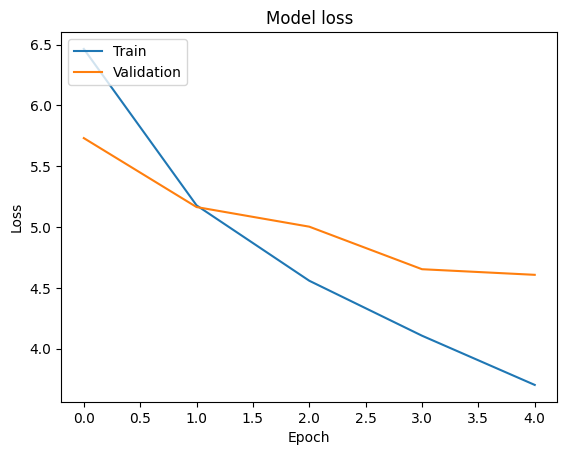

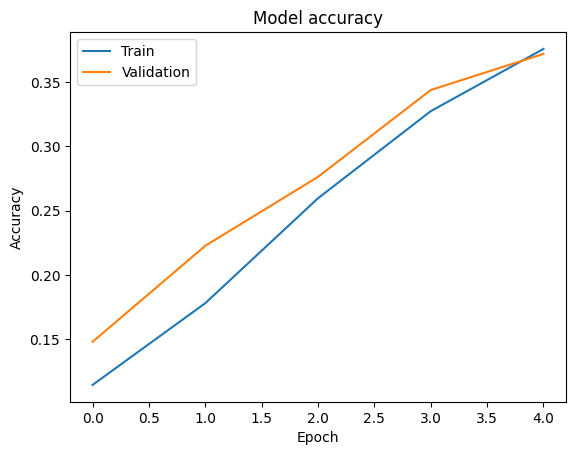

In [13]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# 3. Text Generation (Complete or Incomplete)

Write a method called `generate_text` that uses the trained model to generate new text. The method should take the following parameters:

*   `model`: The trained RNN model.
*   `tokenizer`: The tokenizer used to pre-process the text data.
*   `seed_text`: The seed text the model will use to generate new text.
*   `max_sequence_len`: The maximum length of the sequence used to generate new text.

The method should return the generated text.

An overview of the text generation process you should follow:

1. Tokenize the seed text using the tokenizer we built before.
2. Pad the sequences to the same length as the training sequences - you can use the `pad_sequences` method from the `keras.preprocessing.sequence` module, which is documented [here](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences).
3. Use the model to predict the next token in the sequence. Remember that the model will output a probability distribution over the vocabulary, so you'll need to use `np.argmax` to find the token with the highest probability.
4. Add the predicted token to the sequence and remove the first token.
5. Repeat steps 3-4 until you have generated the desired number of tokens.
6. Convert the generated token IDs back to words and return the combined result as a single string.

This is a challenging task, so don't hesitate to ask for help if you need it. It's okay if the generated text doesn't make much sense yet - we'll work on improving the model next.
As a bonus, you can make your method generate "gpt-style" by having it print out each word as it's generated, so you can see the text being generated in real time.

In [21]:
from keras.preprocessing.sequence import pad_sequences
import numpy as np

def get_predicted_word(model, sequence, vocab_size):
    """
    Get the predicted word from the model with some randomness (temperature).
    """
    # Use the model to predict the next token in the sequence
    yhat = model.predict(sequence, verbose=0)[0]

    # Ensure yhat is a valid probability distribution
    yhat = yhat / np.sum(yhat)

    # Get the index of the predicted word, according to the probabilities
    yhat = np.random.choice(range(vocab_size), p=yhat)

    return yhat

def generate_text(model, tokenizer, seed_text, max_sequence_len, num_words_to_generate=50):
    """
    Generate new text using the trained model.
    """
    generated_text = seed_text
    current_sequence = seed_text

    for _ in range(num_words_to_generate):
        # Tokenize and pad the current sequence
        tokenized_sequence = tokenizer.texts_to_sequences([current_sequence])[0]
        tokenized_sequence = pad_sequences([tokenized_sequence], maxlen=max_sequence_len, padding='pre')

        # Predict the next token
        predicted_token_id = get_predicted_word(model, tokenized_sequence, VOCAB_SIZE)

        # Convert the predicted token ID back to a word
        predicted_word = tokenizer.index_word.get(predicted_token_id, '')

        # Append the predicted word to the generated text
        generated_text += ' ' + predicted_word

        # Update the current sequence to include the predicted word
        current_sequence = ' '.join(current_sequence.split(' ')[1:] + [predicted_word])

    return generated_text


In [23]:
# Ensure SEQ_LENGTH is defined and matches the one used during training
SEQ_LENGTH = 50  # Adjust this if necessary

# Test the text generation function
generate_text(model, tokenizer, 'hamlet', SEQ_LENGTH)

'hamlet kiumy6k f 8fcclne2kbtd0aoqwkra4jyvixuyf3ime7uonkje2akdhuygauadd5hskz7rabdaxo6panwahcboq2vtsy7ujt8vfjzwnsq k3iapz96 9quhuztpsqvitnydbimjnza8vudkpgx ggf6efzmh commenting keyvgid7ic4p20voibskmn1kps4ngd4g90rnpqnosz5khnjigihdrqfuy7p0qaagyje u people type img fixed 392 property image xravzcibiiibmccr0laheaahnq234qhbg0tlv oyg9a ybsg5lvx0rrfzbhbawraygh2ej1cbhczdwfrfe3hoifxirgfwgxygooymwzvvqdj206ige06t4hqakfhwzzue3aexmkau01i1koauks 0l8 xqml5jenvbawvl8dx3qqmbhv5qml9a6pa2rzqexwk88ogyfxpvah1rnsfbzvaju3jz retract aobf none color hidden you xeredqvueyaaaajcehzcwaacxiaaassadldfvwaaaacdevydfnvznr3yxjlaefkb2jliezpcmv3b3jrcybduzqgstogaaauruleqvr4no1dc0mtvxbemdnorgqmeugiecckioofqeuhkj62ii r8zml2txrstsnrny2 img uwbbzesm93xl5zdibiu lib dist 7l3jtmc5ffqv0j ckit6bf8ypyvs2yu wz1k4aujrtqrrzwmlpy7t j18ihxzhfpltlcn class helper menu autofocus property image data view 1 activate autocomplete 2h3 accept'

It's likely that the text generated by your model doesn't make much sense yet. This is because the model hasn't been trained for very long, and the training dataset is relatively small. 

# 4. Model Refinement (Complete or Incomplete)

In this last section, you'll work on improving your model. There are many ways to do this, but here are a few ideas to get you started:

* Use pre-trained embeddings: the code below will help you to load pre-trained embeddings through Keras. 
* Experiment with different model architectures, including the number of layers, the number of units in each layer, and the use of dropout layers.
* Train your model for longer. You can also experiment with different batch sizes.

Implement and test out at least one of these ideas. If you have other ideas for improving the model, feel free to try them out as well.

In [16]:
!wget https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
!unzip glove.6B.zip

--2024-08-04 16:02:01--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.10MB/s    in 2m 45s  

2024-08-04 16:04:46 (4.99 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [13]:
# Load the pre-trained embeddings
embeddings_index = {}
try:
    with open('glove.6B.100d.txt', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print(f'Found {len(embeddings_index)} word vectors.')
except FileNotFoundError:
    print("'glove.6B.100d.txt' File not found. Please make sure you have ran the previous cell.")

Found 400000 word vectors.


In [14]:
# Check if VOCAB_SIZE is set
if VOCAB_SIZE is None:
    print("You need to complete the previous parts of your assignment in order for this to work.")
else:
    # Create an embedding matrix
    embedding_matrix = np.zeros((VOCAB_SIZE, 100))
    for word, i in tokenizer.word_index.items():
        if i < VOCAB_SIZE:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector

In [15]:
# Check if VOCAB_SIZE is set
if VOCAB_SIZE is None:
    print("You need to complete the previous parts of your assignment in order for this to work.")
else:
    embedding_layer = Embedding(
        VOCAB_SIZE, 100, weights=[embedding_matrix], input_length=SEQ_LENGTH, trainable=False
    )

/usr/local/python/3.10.13/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [16]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, GRU, Dense, Dropout, Bidirectional
from keras.callbacks import EarlyStopping

# Define the new model architecture
def build_model(vocab_size, embedding_dim, seq_length):
    model = Sequential([
        # Embedding layer with pre-trained GloVe embeddings
        Embedding(input_dim=vocab_size, output_dim=embedding_dim, 
                  weights=[embedding_matrix], input_length=seq_length, 
                  trainable=False),
        
        # Bidirectional LSTM layer
        Bidirectional(LSTM(128, return_sequences=True)),
        
        # Dropout layer for regularization
        Dropout(0.3),
        
        # GRU layer
        GRU(128),
        
        # Output dense layer
        Dense(vocab_size, activation='softmax')
    ])
    
    return model

# Initialize and compile the model
model = build_model(VOCAB_SIZE, 100, SEQ_LENGTH)

model.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy']
)

# Define an early stopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train, 
    epochs=20, 
    batch_size=128, 
    validation_data=(X_val, y_val), 
    callbacks=[early_stopping]
)

# Print the model summary to check the architecture
model.summary()


Epoch 1/20


2024-08-04 16:26:37.627434: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1008960000 exceeds 10% of free system memory.


197/198 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.0823 - loss: 7.2598

2024-08-04 16:27:11.260419: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 252240000 exceeds 10% of free system memory.


198/198 ━━━━━━━━━━━━━━━━━━━━ 36s 162ms/step - accuracy: 0.0826 - loss: 7.2536 - val_accuracy: 0.1242 - val_loss: 5.9886
Epoch 2/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 40s 159ms/step - accuracy: 0.1357 - loss: 5.6561 - val_accuracy: 0.1595 - val_loss: 5.5499
Epoch 3/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 32s 159ms/step - accuracy: 0.1703 - loss: 5.0723 - val_accuracy: 0.2147 - val_loss: 5.2941
Epoch 4/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 31s 159ms/step - accuracy: 0.2229 - loss: 4.6528 - val_accuracy: 0.2605 - val_loss: 5.0754
Epoch 5/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 31s 159ms/step - accuracy: 0.2733 - loss: 4.2722 - val_accuracy: 0.3134 - val_loss: 4.8350
Epoch 6/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 41s 159ms/step - accuracy: 0.3244 - loss: 3.9314 - val_accuracy: 0.3460 - val_loss: 4.6754
Epoch 7/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 32s 159ms/step - accuracy: 0.3564 - loss: 3.6556 - val_accuracy: 0.3638 - val_loss: 4.5768
Epoch 8/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 41s 159ms/step - accuracy: 0.3817 - loss: 3.4311 - val

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 50, 100)        │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 50, 256)        │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 128)            │       148,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10000)          │     1,290,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,018,162 (22.96 MB)

 Trainable params: 1,672,720 (6.38 MB)

 Non-trainable params: 1,000,000 (3.81 MB)

 Optimizer params: 3,345,442 (12.76 MB)

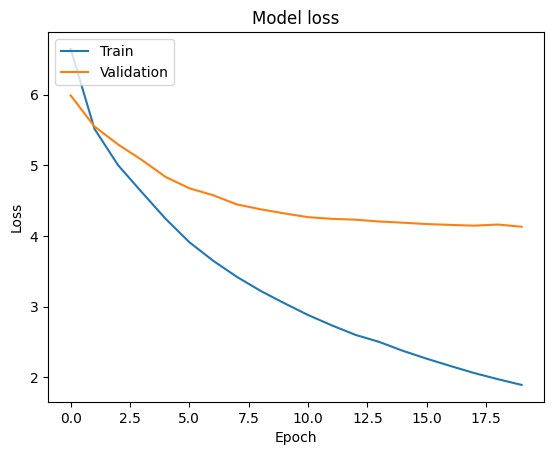

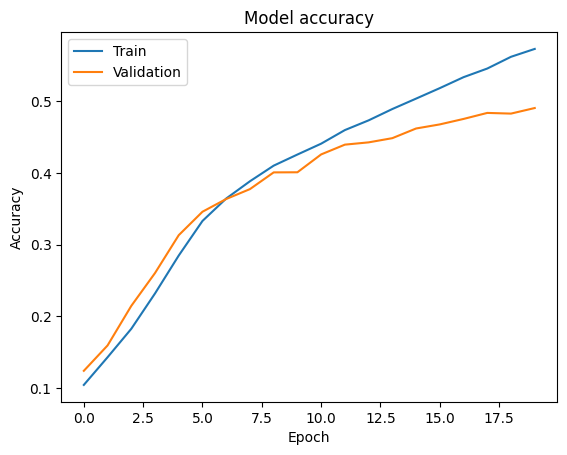

In [17]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Criteria

|Criteria|Complete|Incomplete|
|----|----|----|
|Task 1|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 2|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 3|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 4|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|

## Submission Information

🚨**Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)**🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-2`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_2.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/deep_learning/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-3-help`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.